# Birds Classifications

## Definition of Transfer Learning

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. This area of research bears some relation to the long history of psychological literature on transfer of learning, although formal ties between the two fields are limited. From the practical standpoint, reusing or transferring information from previously learned tasks for the learning of new tasks has the potential to significantly improve the sample efficiency of a reinforcement learning agent.
<br><br>
Ressource from : [Wikipedia](https://en.wikipedia.org/wiki/Transfer_learning)

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input,Dropout, Activation,Concatenate
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

# Split Data

In [2]:
# Splitting the data starts here, we store the path to the training set into a variable for further referencing.

train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'

birds = np.array(list(os.listdir(train_path)))
nr_birds = 20

In [3]:
# pick only 20 type of birds to train on


# np.random.shuffle(birds)
# slicing the data
# birds = birds[:nr_birds]

In [4]:
idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

{0: 'CREAM COLORED WOODPECKER', 1: 'RUFUOS MOTMOT', 2: 'WHITE TAILED TROPIC', 3: 'KOOKABURRA', 4: 'TREE SWALLOW', 5: 'AMERICAN REDSTART', 6: 'EASTERN TOWEE', 7: 'IBERIAN MAGPIE', 8: 'HOOPOES', 9: 'BELTED KINGFISHER', 10: 'CRESTED CARACARA', 11: 'IMPERIAL SHAQ', 12: 'VIOLET GREEN SWALLOW', 13: 'CAPE MAY WARBLER', 14: 'EASTERN MEADOWLARK', 15: 'EUROPEAN GOLDFINCH', 16: 'HOATZIN', 17: 'TAIWAN MAGPIE', 18: 'RED BELLIED PITTA', 19: 'BARRED PUFFBIRD'}


In [5]:
# Function to store labels based on the folders.

def get_data_labels(path, birds, dimensions):
    data = []
    labels = []

    for bird in birds:
        imgs = [cv2.resize(cv2.imread(img), dimensions, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + bird + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[bird])
            
    return np.array(data), np.array(labels)

In [6]:
data_train, labels_train = get_data_labels(train_path, idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels(test_path, idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels(valid_path, idx_to_name.values(), (224,224))

print(data_train.shape)

(3041, 224, 224, 3)


In [7]:
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [8]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

# Implementation

In [9]:
base_mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_mobilenet.layers:
  # freeze layers
  layer.trainable = False

# base_mobilenet.trainable = False
base_mobilenet.summary()

2022-05-02 13:17:50.598731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 13:17:50.604463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

17235968/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                       

In [10]:
new_model = Sequential()
new_model.add(base_mobilenet)

new_model.add(Flatten()) 
new_model.add(Activation('relu'))
new_model.add(Dense(nr_birds)) 
new_model.add(Activation('softmax'))

# # use “get_layer” method to save the last layer of the network
# last_layer = base_mobilenet.get_layer('block5_pool')
# # save the output of the last layer to be the input of the next layer
# last_output = last_layer.output

# # flatten the classifier input which is output of the last layer of VGG16 model
# x = Flatten()(last_output)

# # add our new softmax layer with 3 hidden units
# x = Dense(nr_birds, activation='softmax', name='softmax')(x)

# print the new_model summary
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 activation (Activation)     (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 20)                1003540   
                                                                 
 activation_1 (Activation)   (None, 20)                0         
                                                                 
Total params: 4,232,404
Trainable params: 1,003,540
Non-trainable params: 3,228,864
______________________________________

In [11]:
# instantiate a new_model using keras’s Model class
# new_model = Model(inputs=base_mobilenet.input, outputs=x)




In [12]:
new_model.compile(SGD(lr=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath='mobile_net_birds.model.h5', save_best_only=True)

history = new_model.fit(data_train, labels_train, steps_per_epoch=len(data_train),
validation_data=(data_test, labels_test), validation_steps=3, epochs=100, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='loss', value=0.0001, verbose=1)])

Epoch 1/100


2022-05-02 13:17:56.363487: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-02 13:17:57.277541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3041/3041 [==============================] - ETA: 0s - loss: 71.3120 - accuracy: 0.7547

2022-05-02 13:18:32.406360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3041/3041 [==============================] - 37s 12ms/step - loss: 71.3120 - accuracy: 0.7547 - val_loss: 34.6729 - val_accuracy: 0.8900
Epoch 2/100
3041/3041 [==============================] - 35s 12ms/step - loss: 10.2802 - accuracy: 0.9599 - val_loss: 5.6560 - val_accuracy: 0.9600
Epoch 3/100
3041/3041 [==============================] - 37s 12ms/step - loss: 3.0293 - accuracy: 0.9849 - val_loss: 18.5275 - val_accuracy: 0.9500
Epoch 4/100
3041/3041 [==============================] - 35s 12ms/step - loss: 2.2554 - accuracy: 0.9868 - val_loss: 4.8510 - val_accuracy: 0.9600
Epoch 5/100
3041/3041 [==============================] - 37s 12ms/step - loss: 0.9175 - accuracy: 0.9915 - val_loss: 7.2886 - val_accuracy: 0.9700
Epoch 6/100
3041/3041 [==============================] - 34s 11ms/step - loss: 1.1344 - accuracy: 0.9921 - val_loss: 20.2316 - val_accuracy: 0.9900
Epoch 7/100
3041/3041 [==============================] - 36s 12ms/step - loss: 0.2486 - accuracy: 0.9980 - val_loss: 20.1234 

In [14]:
# Analyze Training Data

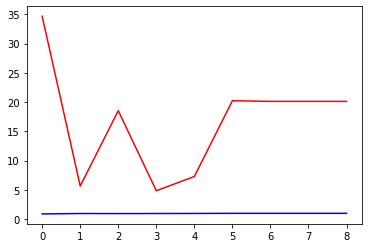

In [15]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

In [16]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [17]:
# we use the validation data to verify the accuracy
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Valid Accuracy:", accuracy)

Valid Accuracy: 0.96


In [18]:
# we use the test data to verify the accuracy
accuracy = get_accuracy(new_model, data_test, labels_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.99


In [19]:
new_model.save('mobile_net.h5')

## Running Predictions From Saved Model

In [20]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(os.listdir(train_path)))
  for i, pred in enumerate(predicted_arr):
    return all_birds_cat[np.argmax(pred)]


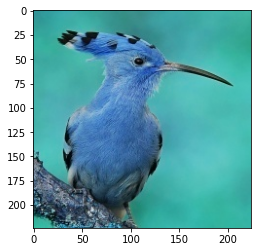

HOOPOES


2022-05-02 13:23:21.272067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:

model = load_model('mobile_net.h5')

predict_image_path = './dataset/20test/HOOPOES/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

# img = cv2.resize(cv2.imread(predict_image_path), (224,224), interpolation=cv2.INTER_AREA)
img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)
label = decode(predictions)

print(label)

# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)